In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import pickle

from utils.Param import get_default_param
from utils.eval import fpr, retrieval_recall_K

from network.model_fn import triplet_model_fn
from network.dataset.sem_patchdata import input_fn
from network.train import TripletEstimator

In [2]:
# set seed for reproduction
np.random.seed(2019)
tf.set_random_seed(2019)

In [3]:
# parameters (adjust as needed)
log_dir = './log/human'
param = get_default_param(mode='AUSTIN', log_dir=log_dir)

In [4]:
param.data_dir = './Data/austin'
param.train_datasets = 'human_patch'
param.test_datasets = 'campus_patch'
param.batch_size = 64
param.n_epoch = 20
param.n_triplet_samples = 500000
param.train_log_every   = 100000

test_datasets = 'scene_patch'

### data pipeline

In [5]:
tf.logging.info("Preparing data pipeline ...")
with tf.device('/cpu:0'), tf.name_scope('input'):
    train_dataset, train_data_sampler = input_fn(
        data_dir=param.data_dir,
        base_patch_size=param.base_patch_size,
        patches_per_row=param.patches_per_row,
        patches_per_col=param.patches_per_col,
        batch_size=param.batch_size,
        patch_size=param.patch_size,
        n_channels=param.n_channels
    )
    test_dataset, test_data_sampler = input_fn(
        data_dir=param.data_dir,
        base_patch_size=param.base_patch_size,
        patches_per_row=param.patches_per_row,
        patches_per_col=param.patches_per_col,
        batch_size=param.batch_size,
        patch_size=param.patch_size,
        n_channels=param.n_channels
    )
    test_dataset_2, test_data_sampler_2 = input_fn(
        data_dir=param.data_dir,
        base_patch_size=param.base_patch_size,
        patches_per_row=param.patches_per_row,
        patches_per_col=param.patches_per_col,
        batch_size=param.batch_size,
        patch_size=param.patch_size,
        n_channels=param.n_channels
    )    
    data_iterator = tf.data.Iterator.from_structure(
        train_dataset.output_types,
        train_dataset.output_shapes
    )
    train_dataset_init = data_iterator.make_initializer(train_dataset)
    test_dataset_init = data_iterator.make_initializer(test_dataset)
    test_dataset_init_2 = data_iterator.make_initializer(test_dataset_2)
    batch_data = data_iterator.get_next()

INFO:tensorflow:Preparing data pipeline ...


### load data

In [6]:
train_data_sampler.load_dataset(
    dir_name=param.train_datasets,
    ext='bmp',
    patch_size=param.patch_size,
    n_channels=param.n_channels,
    debug=True
)

Loading dataset human_patch: 100%|██████████| 9850/9850 [02:16<00:00, 72.30it/s] 
Load triplet samples: 1000000it [00:02, 490362.92it/s]
Load matched pairs: 100000it [00:00, 351527.87it/s]
Load retrieval set: 59100it [00:00, 387115.13it/s]


-- Dataset loaded   : human_patch
-- # patches        : 768300
-- # triplet samples: 1000000
-- # matched pairs  : 50000
-- # retrieval set  : 59100


In [7]:
test_data_sampler.load_dataset(
    dir_name=param.test_datasets,
    ext='bmp',
    patch_size=param.patch_size,
    n_channels=param.n_channels,
    debug=True
)

Loading dataset campus_patch: 100%|██████████| 4500/4500 [01:54<00:00, 39.42it/s]
Load triplet samples: 1000000it [00:01, 530525.32it/s]
Load matched pairs: 100000it [00:00, 213804.64it/s]
Load retrieval set: 27000it [00:00, 420196.09it/s]

-- Dataset loaded   : campus_patch
-- # patches        : 351000
-- # triplet samples: 1000000
-- # matched pairs  : 50000
-- # retrieval set  : 27000


In [8]:
test_data_sampler_2.load_dataset(
    dir_name=test_datasets,
    ext='bmp',
    patch_size=param.patch_size,
    n_channels=param.n_channels,
    debug=True
)

Loading dataset scene_patch: 100%|██████████| 2550/2550 [00:49<00:00, 51.15it/s]
Load triplet samples: 1000000it [00:01, 539759.46it/s]
Load matched pairs: 100000it [00:00, 282691.24it/s]
Load retrieval set: 15300it [00:00, 87115.86it/s]

-- Dataset loaded   : scene_patch
-- # patches        : 198900
-- # triplet samples: 1000000
-- # matched pairs  : 50000
-- # retrieval set  : 15300


### compute data statistics

In [9]:
tf.logging.info('Loading training stats: %s' % param.train_datasets)
try:
    file = open(os.path.join(param.log_dir, 'stats_%s.pkl' % param.train_datasets), 'rb')
    mean, std = pickle.load(file)
except:
    tf.logging.info('Calculating train data stats (mean, std)')
    mean, std = train_data_sampler.generate_stats()
    pickle.dump(
        [mean, std], 
        open(os.path.join(param.log_dir, 'stats_%s.pkl' % param.train_datasets), 'wb')
    )
tf.logging.info('Mean: {:.5f}'.format(mean))
tf.logging.info('Std : {:.5f}'.format(std))
train_data_sampler.normalize_data(mean, std)
test_data_sampler.normalize_data(mean, std)
test_data_sampler_2.normalize_data(mean, std)

INFO:tensorflow:Loading training stats: human_patch
INFO:tensorflow:Calculating train data stats (mean, std)
INFO:tensorflow:Mean: 0.44456
INFO:tensorflow:Std : 0.26916


Normalizing data: 100%|██████████| 198900/198900 [00:11<00:00, 16679.00it/s]


### build model

In [10]:
tf.logging.info("Creating the model ...")
anchors, positives, negatives = batch_data
spec = triplet_model_fn(
    anchors, positives, negatives, n_feats=param.n_features,
    mode='TRAIN', cnn_name=param.cnn_name, loss_name=param.loss_name,
    optimizer_name=param.optimizer_name,
    margin=param.margin,
    use_regularization_loss=param.use_regularization,
    learning_rate=param.learning_rate,
    shared_batch_layers=True,
    name='triplet-net'
)
estimator = TripletEstimator(spec, save_dir=param.log_dir)

INFO:tensorflow:Creating the model ...
INFO:tensorflow:CNN: ftfy
INFO:tensorflow:LOSS: spreadout
INFO:tensorflow:OPTIMIZER: Momentum


### Training

In [11]:
K=[1, 5, 10, 20, 30]

all_loss = [] # avg. loss over epochs
train_fpr95 = [] # fpr95 with training dataset
train_retrieval = [] # retrieval with training dataset
test_fpr95 = []
test_retrieval = []
test_fpr95_2 = []
test_retrieval_2 = []

tf.logging.info('='*50)
tf.logging.info('Start training ...')
tf.logging.info('='*50)
for epoch in range(param.n_epoch):
    tf.logging.info('-'*50)
    tf.logging.info('TRAIN {:d}, {:s} start ...'.format(epoch, param.train_datasets))
    train_data_sampler.set_mode(0)
    train_data_sampler.set_n_triplet_samples(param.n_triplet_samples)
    loss = estimator.train(
        dataset_initializer=train_dataset_init,
        log_every=param.train_log_every
    )
    all_loss.append(loss)
    tf.logging.info('-'*50)

    # for evaluation with training dataset
    tf.logging.info('-'*50)
    tf.logging.info('TEST {:d}, {:s} start ...'.format(epoch, param.train_datasets))
    train_data_sampler.set_mode(1)
    #train_data_sampler.set_n_matched_pairs(1000)
    test_match = estimator.run_match(train_dataset_init)
    fpr95 = fpr(test_match.labels, test_match.scores, recall_rate=0.95)
    train_fpr95.append(fpr95)
    tf.logging.info('FPR95: {:.5f}'.format(fpr95))
    
    train_data_sampler.set_mode(2)
    test_rrr = estimator.run_retrieval(train_dataset_init)
    rrr = retrieval_recall_K(
        features=test_rrr.features,
        labels=train_data_sampler.get_labels(test_rrr.index),
        is_query=test_rrr.scores,
        K=K
    )
    train_retrieval.append(rrr)
    tf.logging.info('Retrieval: {}'.format(rrr))
    tf.logging.info('-'*50)
    
    # for evaluation with test dataset
    tf.logging.info('-'*50)
    tf.logging.info('TEST {:d}, {:s} start ...'.format(epoch, param.test_datasets))
    test_data_sampler.set_mode(1)
    #test_data_sampler.set_n_matched_pairs(1000)
    test_match = estimator.run_match(test_dataset_init)
    fpr95 = fpr(test_match.labels, test_match.scores, recall_rate=0.95)
    test_fpr95.append(fpr95)
    tf.logging.info('FPR95: {:.5f}'.format(fpr95))
    
    test_data_sampler.set_mode(2)
    test_rrr = estimator.run_retrieval(test_dataset_init)
    rrr = retrieval_recall_K(
        features=test_rrr.features,
        labels=test_data_sampler.get_labels(test_rrr.index),
        is_query=test_rrr.scores,
        K=K
    )
    test_retrieval.append(rrr)
    tf.logging.info('Retrieval: {}'.format(rrr))
    tf.logging.info('-'*50)
    
    # for evaluation with test dataset
    tf.logging.info('-'*50)
    tf.logging.info('TEST {:d}, {:s} start ...'.format(epoch, test_datasets))
    test_data_sampler_2.set_mode(1)
    #test_data_sampler.set_n_matched_pairs(1000)
    test_match = estimator.run_match(test_dataset_init_2)
    fpr95 = fpr(test_match.labels, test_match.scores, recall_rate=0.95)
    test_fpr95_2.append(fpr95)
    tf.logging.info('FPR95: {:.5f}'.format(fpr95))
    
    test_data_sampler_2.set_mode(2)
    test_rrr = estimator.run_retrieval(test_dataset_init_2)
    rrr = retrieval_recall_K(
        features=test_rrr.features,
        labels=test_data_sampler_2.get_labels(test_rrr.index),
        is_query=test_rrr.scores,
        K=K
    )
    test_retrieval_2.append(rrr)
    tf.logging.info('Retrieval: {}'.format(rrr))
    tf.logging.info('-'*50)
    
    # save checkpoint
    if epoch % param.save_every == 0 or epoch+1 == param.n_epoch:
        estimator.save(param.project_name, global_step=epoch)
    
    #if epoch > 10:
    #    break

INFO:tensorflow:==================================================
INFO:tensorflow:Start training ...
INFO:tensorflow:==================================================
INFO:tensorflow:--------------------------------------------------
INFO:tensorflow:TRAIN 0, human_patch start ...
INFO:tensorflow:Avg. triplet loss: 0.155071
INFO:tensorflow:Exhausted all data in the dataset (7813)!
INFO:tensorflow:--------------------------------------------------
INFO:tensorflow:--------------------------------------------------
INFO:tensorflow:TEST 0, human_patch start ...
INFO:tensorflow:Exhausted dataset for run_match: 100000
INFO:tensorflow:FPR95: 0.05450
INFO:tensorflow:Exhausted dataset for run_retrieval: 59100
INFO:tensorflow:Retrieval: [0.8894924  0.9348223  0.94873095 0.96020305 0.9661929 ]
INFO:tensorflow:--------------------------------------------------
INFO:tensorflow:--------------------------------------------------
INFO:tensorflow:TEST 0, campus_patch start ...
INFO:tensorflow:Exhauste

INFO:tensorflow:FPR95: 0.02502
INFO:tensorflow:Exhausted dataset for run_retrieval: 59100
INFO:tensorflow:Retrieval: [0.91177666 0.95111674 0.9618274  0.97071064 0.9753807 ]
INFO:tensorflow:--------------------------------------------------
INFO:tensorflow:--------------------------------------------------
INFO:tensorflow:TEST 5, campus_patch start ...
INFO:tensorflow:Exhausted dataset for run_match: 100000
INFO:tensorflow:FPR95: 0.02416
INFO:tensorflow:Exhausted dataset for run_retrieval: 27000
INFO:tensorflow:Retrieval: [0.9213333  0.96033335 0.9708889  0.97911114 0.98355556]
INFO:tensorflow:--------------------------------------------------
INFO:tensorflow:--------------------------------------------------
INFO:tensorflow:TEST 5, scene_patch start ...
INFO:tensorflow:Exhausted dataset for run_match: 100000
INFO:tensorflow:FPR95: 0.03444
INFO:tensorflow:Exhausted dataset for run_retrieval: 15300
INFO:tensorflow:Retrieval: [0.9282353  0.96117646 0.97313726 0.9823529  0.98588234]
INFO:

INFO:tensorflow:--------------------------------------------------
INFO:tensorflow:--------------------------------------------------
INFO:tensorflow:TEST 10, scene_patch start ...
INFO:tensorflow:Exhausted dataset for run_match: 100000
INFO:tensorflow:FPR95: 0.02490
INFO:tensorflow:Exhausted dataset for run_retrieval: 15300
INFO:tensorflow:Retrieval: [0.9445098  0.9739216  0.98176473 0.98745096 0.99019605]
INFO:tensorflow:--------------------------------------------------
INFO:tensorflow:Save checkpoint @ ./log/human/triplet_net-10
INFO:tensorflow:--------------------------------------------------
INFO:tensorflow:TRAIN 11, human_patch start ...
INFO:tensorflow:Avg. triplet loss: 0.086083
INFO:tensorflow:Exhausted all data in the dataset (7813)!
INFO:tensorflow:--------------------------------------------------
INFO:tensorflow:--------------------------------------------------
INFO:tensorflow:TEST 11, human_patch start ...
INFO:tensorflow:Exhausted dataset for run_match: 100000
INFO:te

INFO:tensorflow:TRAIN 16, human_patch start ...
INFO:tensorflow:Avg. triplet loss: 0.077229
INFO:tensorflow:Exhausted all data in the dataset (7813)!
INFO:tensorflow:--------------------------------------------------
INFO:tensorflow:--------------------------------------------------
INFO:tensorflow:TEST 16, human_patch start ...
INFO:tensorflow:Exhausted dataset for run_match: 100000
INFO:tensorflow:FPR95: 0.01715
INFO:tensorflow:Exhausted dataset for run_retrieval: 59100
INFO:tensorflow:Retrieval: [0.9325888  0.9640609  0.973198   0.97994924 0.98350257]
INFO:tensorflow:--------------------------------------------------
INFO:tensorflow:--------------------------------------------------
INFO:tensorflow:TEST 16, campus_patch start ...
INFO:tensorflow:Exhausted dataset for run_match: 100000
INFO:tensorflow:FPR95: 0.01908
INFO:tensorflow:Exhausted dataset for run_retrieval: 27000
INFO:tensorflow:Retrieval: [0.9431111 0.973     0.9814444 0.9878889 0.9903333]
INFO:tensorflow:----------------

### Plot results

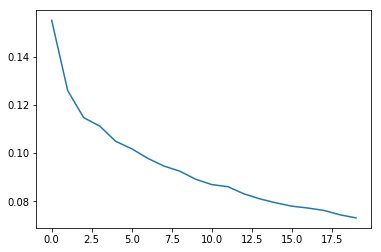

In [12]:
plt.plot(all_loss)

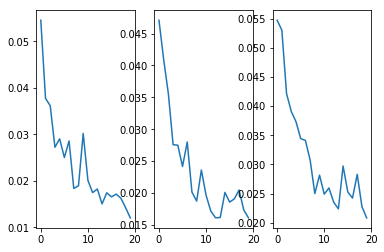

In [13]:
fig, ax = plt.subplots(1, 3)
ax[0].plot(train_fpr95)
ax[1].plot(test_fpr95)
ax[2].plot(test_fpr95_2)

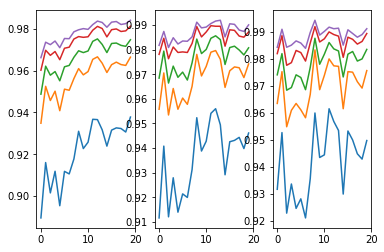

In [14]:
fig, ax = plt.subplots(1, 3)
ax[0].plot(train_retrieval)
ax[1].plot(test_retrieval)
ax[2].plot(test_retrieval_2)

In [15]:
# save results
out_dir = os.path.join(param.log_dir, 'metrics_{}_{}.npy'.format(
    param.train_datasets, param.train_datasets
))
metric = dict(
    loss=np.array(all_loss),
    fpr95=np.array(train_fpr95),
    retrieval=np.asarray(train_retrieval)
)
np.save(out_dir, metric)

out_dir = os.path.join(param.log_dir, 'metrics_{}_{}.npy'.format(
    param.train_datasets, param.test_datasets
))
metric = dict(
    loss=np.array(all_loss),
    fpr95=np.array(test_fpr95),
    retrieval=np.asarray(test_retrieval)
)
np.save(out_dir, metric)

out_dir = os.path.join(param.log_dir, 'metrics_{}_{}.npy'.format(
    param.train_datasets, test_datasets
))
metric = dict(
    loss=np.array(all_loss),
    fpr95=np.array(test_fpr95_2),
    retrieval=np.asarray(test_retrieval_2)
)
np.save(out_dir, metric)